In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow.keras.models     import Model
from tensorflow.keras.layers     import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ---------- hyperparameters ----------
EPOCHS       = 200
BATCH_SIZE   = 64
LATENT_SPACE = 32

tf.random.set_seed(10)

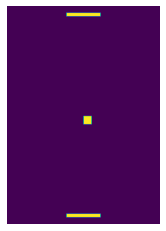

In [4]:
# ---------- training data ----------
screens = np.load('/content/drive/MyDrive/Colab Notebooks/Datasets/_screens.npy')
screens = screens.reshape( (-1, 640, 448, 1) )
screens = screens.astype(np.float32)

plt.axis('off')
plt.imshow(screens[0].reshape(640, 448))
plt.show()

## Create the models

In [5]:
# encoder
i = Input( shape=(640, 448, 1) )

x = Conv2D( filters=16, kernel_size=16, strides=6, padding='same')(i)
x = LeakyReLU()(x)
# x = Dropout(0.2)(x)

x = Conv2D( filters=16, kernel_size=8 , strides=6, padding='same')(x)
x = LeakyReLU()(x)
# x = Dropout(0.2)(x)

x = Conv2D( filters=16, kernel_size=4 , strides=2, padding='same')(x)
x = LeakyReLU()(x)
# x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense( LATENT_SPACE, activation='sigmoid' )(x)

encoder = Model(i, x)
print(encoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 448, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 107, 75, 16)       4112      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 107, 75, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 13, 16)        16400     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 18, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 16)          4112      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 9, 7, 16)          0     

In [6]:
# decoder
i = Input( shape=(LATENT_SPACE) )

x = Dense( 4480 )(i)
x = LeakyReLU()(x)

x = Reshape( target_shape=(20, 14, 16) )(x)

x = Conv2DTranspose( 16, kernel_size=8, strides=2, padding='same' )(x)
x = LeakyReLU()(x)

x = Conv2DTranspose( 16, kernel_size=8, strides=4, padding='same' )(x)
x = LeakyReLU()(x)

x = Conv2DTranspose( 1 , kernel_size=8, strides=4, padding='same', activation='sigmoid' )(x)

decoder = Model(i, x)
print(decoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4480)              147840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4480)              0         
_________________________________________________________________
reshape (Reshape)            (None, 20, 14, 16)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 40, 28, 16)        16400     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 40, 28, 16)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 160, 112, 16)      1640

In [7]:
# autoencoder
i = Input( shape=(640, 448, 1) )
x = encoder(i)
x = decoder(x)

autoencoder = Model(i, x)
autoencoder.compile( loss='mse', optimizer='rmsprop' )
print(autoencoder.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 640, 448, 1)]     0         
_________________________________________________________________
model (Functional)           (None, 32)                56912     
_________________________________________________________________
model_1 (Functional)         (None, 640, 448, 1)       181665    
Total params: 238,577
Trainable params: 238,577
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [ ]:
# ---------- training loop ----------
history = autoencoder.fit( x=screens, y=screens, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.05 )
history = history.history

Epoch 1/200
39/67 [================>.............] - ETA: 2s - loss: 0.1201

## Error Visualization

In [ ]:
# plot model loss over time
plt.plot(history['loss']        , label='loss')
plt.plot(history['val_loss']    , label='val_loss')

plt.legend(loc=1)
plt.show()

In [ ]:
# reconstructed & original images
batch = np.random.randint(screens.shape[0], size=10)

originals   = np.reshape(screens[batch]                     , (10, 640, 448))
predictions = np.reshape(autoencoder.predict(screens[batch]), (10, 640, 448))

# combine the predicted and original arrays
images = np.concatenate((originals, predictions))

# Create a figure from the predicted and real images
cols, rows = 10, 2

fig=plt.figure(figsize=(20, 4))

for i in range(1, cols*rows +1):
    fig.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(images[i-1])

# Save the figure to the images dir
plt.show()

In [ ]:
# differences between reconstructed & original images
differences = np.absolute(np.subtract(originals, predictions))

# Create a figure from these differences
cols, rows = 10, 1

fig=plt.figure(figsize=(20, 2))

for i in range(1, cols*rows + 1):
    fig.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(differences[i-1])

# Save the figure to the images dir
plt.show()

## Save the model locally

In [ ]:
encoder.save('models\encoder.h5')
decoder.save('models\decoder.h5')